In [ ]:
# Libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 40)
pd.set_option('display.width', 2000)
import matplotlib.pyplot as plt
import networkx as nx

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import torch
from sklearn.manifold import TSNE
from scipy import spatial
from stellargraph import StellarGraph
from stellargraph.data import BiasedRandomWalk
from gensim.models import Word2Vec
import optuna
from optuna.trial import TrialState
import random

In [ ]:
# Set device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

# Set the random seeds for deterministic results.
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
# Import snomed distance
path = r'data/international_snomed_distance.csv'
snomed_distance = pd.read_csv(path, index_col=0)

In [4]:
# Convert to str
snomed_distance.index = snomed_distance.index.astype(str)
# Get reciprocal
reciprocal_snomed_distance = 1 / snomed_distance
reciprocal_snomed_distance.replace([np.inf, -np.inf], np.nan, inplace=True)
# Melt
melted_reciprocal_snomed_distance = reciprocal_snomed_distance.melt(ignore_index=False)
melted_reciprocal_snomed_distance.reset_index(inplace=True)
melted_reciprocal_snomed_distance.columns = ['source', 'target', 'weight']
melted_reciprocal_snomed_distance['source'] = melted_reciprocal_snomed_distance['source'].astype(str)
# Filter away long connections
melted_reciprocal_snomed_distance['weight'] = np.where((melted_reciprocal_snomed_distance['weight'] < 0.2), 0, melted_reciprocal_snomed_distance['weight'])
# Filter for those where not 0
melted_reciprocal_snomed_distance = melted_reciprocal_snomed_distance[melted_reciprocal_snomed_distance['weight'] != 0]
# Drop Nan
melted_reciprocal_snomed_distance.dropna(inplace=True)
# Get frequency count
melted_reciprocal_snomed_distance_value_counts = pd.DataFrame(melted_reciprocal_snomed_distance.weight.value_counts().reset_index())
melted_reciprocal_snomed_distance_value_counts.columns = ['distance', 'weight']

In [8]:
melted_reciprocal_snomed_distance


,source,target,weight
1,202752002,52011008,0.25
2,197632002,52011008,0.20
3,205824006,52011008,0.25
4,423125000,52011008,0.50
5,90325002,52011008,0.25
...,...,...,...
7257630,5505005,65323003,0.20
7257631,425558002,65323003,0.20
7257632,262955000,65323003,0.25
7257633,367403001,65323003,0.20


In [10]:
# Create graph
nxG=nx.from_pandas_edgelist(melted_reciprocal_snomed_distance, 'source', 'target', edge_attr='weight')

In [20]:
nx.info(nxG)
nx.is_directed(nxG)
nx.is_connected(nxG)
nxG.size()

'Graph with 2694 nodes and 2788159 edges'

False

True

2788159

In [8]:
def define_params(trial):
    # We optimize the number of dimensions, p, q and lambdas for edge weighting.
    n_dimensions = trial.suggest_categorical("n_dimensions{}", [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024])
    p_value = trial.suggest_float("p_value", 0.000001, 5, log=False)
    q_value = trial.suggest_float("q_value", 0.000001, 5, log=False)
    lambda_1 = trial.suggest_float("lambda_1", 0.000001, 1, log=True)
    lambda_2 = trial.suggest_float("lambda_2", 0.000001, 1, log=True)

    return n_dimensions, p_value, q_value, lambda_1, lambda_2

In [6]:
def objective(trial):

    # Generate the model.
    n_dimensions, p_value, q_value, lambda_1, lambda_2 = define_params(trial)

    n_dimensions = 128
    p_value = 5.0
    q_value = 0.5

    # Create new edge weightings
    replace_values = {}
    for i in range(len(melted_reciprocal_snomed_distance_value_counts)):
        replace_values[melted_reciprocal_snomed_distance_value_counts.iloc[i, 0]] = melted_reciprocal_snomed_distance_value_counts.iloc[i, 0] / melted_reciprocal_snomed_distance_value_counts.iloc[i, 1]

    # Apply new weights
    melted_reciprocal_snomed_distance2 = melted_reciprocal_snomed_distance.replace({"weight": replace_values})  
    # Make graph
    SG = StellarGraph(edges = melted_reciprocal_snomed_distance2)
    # Define random walk
    rw = BiasedRandomWalk(SG)
    # Define walk length - could also be a hyperparameter in future
    walk_length = 100

    weighted_walks = rw.run(
        nodes=SG.nodes(),  # root nodes
        length=walk_length,  # maximum length of a random walk
        n=10,  # number of random walks per root node
        p=p_value,  # Defines (unormalised) probability, 1/p, of returning to source node
        q=q_value,  # Defines (unormalised) probability, 1/q, for moving away from source node
        weighted=True,  # for weighted random walks
        seed=0,  # random seed fixed for reproducibility
    )

    weighted_model = Word2Vec(
        weighted_walks, size=n_dimensions, window=5, min_count=0, sg=1, workers=1, iter=1
    )

    # Retrieve node embeddings and corresponding subjects
    node_ids = weighted_model.wv.index2word  # list of node IDs
    weighted_node_embeddings = (
        weighted_model.wv.vectors
    )

    # Get closest point for each point
    distance,index = spatial.KDTree(weighted_node_embeddings).query(weighted_node_embeddings, k=2)
    # Filter for slice to exsclude self
    index = index[:,1]
    # Get snomed distance for each clostest pair
    distance_list = []
    for n in range(len(index)):
        distance = snomed_distance.loc[node_ids[index[n]], node_ids[n]]
        distance_list.append(distance)
    distance_arr = np.array(distance_list)

    # Get mean for metric
    mean_snomed_distance_metric = distance_arr.mean()

    print('mean_snomed_distance_metric:', mean_snomed_distance_metric)

    return mean_snomed_distance_metric

In [9]:
# Run optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=2)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics:")
print("Number of finished trials:", len(study.trials))
print("Number of pruned trials:", len(pruned_trials))
print("Number of complete trials:", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("Value:", trial.value)

print("Params:")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-05-09 13:36:29,152] A new study created in memory with name: no-name-d265588b-ebab-4411-a820-3df684880dbb
[I 2023-05-09 14:01:38,815] Trial 0 finished with value: 1.77728285077951 and parameters: {'n_dimensions{}': 32, 'p_value': 0.8100579326978089, 'q_value': 1.3304307310386485, 'lambda_1': 0.06414697540066383, 'lambda_2': 0.017168004232510282}. Best is trial 0 with value: 1.77728285077951.


mean_snomed_distance_metric: 1.77728285077951


[I 2023-05-09 14:27:08,432] Trial 1 finished with value: 1.77728285077951 and parameters: {'n_dimensions{}': 256, 'p_value': 1.6182371407793337, 'q_value': 3.2441195107588854, 'lambda_1': 0.00038154479645470144, 'lambda_2': 1.0533457720088694e-05}. Best is trial 0 with value: 1.77728285077951.


mean_snomed_distance_metric: 1.77728285077951
Study statistics:
Number of finished trials: 2
Number of pruned trials: 0
Number of complete trials: 2
Best trial:
Value: 1.77728285077951
Params:
    n_dimensions{}: 32
    p_value: 0.8100579326978089
    q_value: 1.3304307310386485
    lambda_1: 0.06414697540066383
    lambda_2: 0.017168004232510282


In [76]:
# Remove those with not many nodes close in snomed
nodes_to_remove = []

# Create new edge weightings
replace_values = {}
for i in range(len(melted_reciprocal_snomed_distance_value_counts)):
    replace_values[melted_reciprocal_snomed_distance_value_counts.iloc[i, 0]] = melted_reciprocal_snomed_distance_value_counts.iloc[i, 0] / melted_reciprocal_snomed_distance_value_counts.iloc[i, 1]

# Apply new weights
melted_reciprocal_snomed_distance2 = melted_reciprocal_snomed_distance.replace({"weight": replace_values})  
# Make graph
SG = StellarGraph(edges = melted_reciprocal_snomed_distance2)

# To networkx
nxG = SG.to_networkx()

z = -1
for node_id in node_ids:
    z += 1
    if z % 100 == 0:
        print(z)
    # get the list of edges connected to the node with ID "node_id"
    edges = [(u, v, d["weight"]) for u, v, d in nxG.edges(data=True) if u == node_id or v == node_id]

    # Compute number of nodes that atre close in snomed
    n_close_nodes = sum(1 for u, v, w in edges if w > 0.000001)
    #print(n_close_nodes)

    # Set threshold
    if n_close_nodes <= 10:
        nodes_to_remove.append(node_id)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600


In [77]:
nodes_to_remove
len(nodes_to_remove)

['233787006',
 '123845008',
 '66999008',
 '89627008',
 '429659006',
 '446096008',
 '95563007',
 '255143004',
 '417357006',
 '203681002',
 '266569009',
 '295124009',
 '200938002',
 '399187006',
 '302820008',
 '417425009',
 '276883000',
 '12204004',
 '198324001',
 '267889007',
 '14094001',
 '198033005',
 '235941008',
 '55822004',
 '237499004',
 '34713006',
 '399933001',
 '49420001',
 '276661002',
 '97881000119105',
 '416956002',
 '50792001',
 '363732003',
 '6374002',
 '233658003',
 '698296002',
 '1082601000119104',
 '1082611000119101',
 '239915006',
 '723665008',
 '239912009',
 '427910000',
 '72470008',
 '91926002',
 '74445007',
 '202733008',
 '44332000',
 '25825004',
 '44465007',
 '14756005',
 '8635005',
 '129635004',
 '13595002',
 '193462001',
 '54840006',
 '232440009',
 '94225005',
 '402382008',
 '307091009',
 '78768009',
 '78975002',
 '254894004',
 '95195003',
 '82649003',
 '134031000119108',
 '424404003',
 '233786002',
 '369001000119100',
 '204878001',
 '41299009',
 '94602001',
 '24

561

In [80]:
# Remove
melted_reciprocal_snomed_distance3 = melted_reciprocal_snomed_distance2[~melted_reciprocal_snomed_distance2['source'].isin(nodes_to_remove)]
melted_reciprocal_snomed_distance3 = melted_reciprocal_snomed_distance3[~melted_reciprocal_snomed_distance3['target'].isin(nodes_to_remove)]

In [83]:
melted_reciprocal_snomed_distance3
melted_reciprocal_snomed_distance3.source.nunique()
melted_reciprocal_snomed_distance3.target.nunique()

,source,target,weight
1,202752002,52011008,1.129442e-07
3,205824006,52011008,1.129442e-07
4,423125000,52011008,6.397789e-06
5,90325002,52011008,1.129442e-07
6,38101003,52011008,7.399482e-08
...,...,...,...
7257628,41345002,65323003,1.129442e-07
7257630,5505005,65323003,7.399482e-08
7257632,262955000,65323003,1.129442e-07
7257633,367403001,65323003,7.399482e-08


2133

2133

In [ ]:
### Final run ###
p_value = 0.1
q_value = 6.0

# Make graph
SG = StellarGraph(edges = melted_reciprocal_snomed_distance3)
# Define random walk
rw = BiasedRandomWalk(SG)
# Define walk length - could also be a hyperparameter
walk_length = 1000

SG.info()

print('Getting walks...')

weighted_walks_1000_3 = rw.run(
    nodes=SG.nodes(),  # root nodes
    length=walk_length,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=p_value,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=q_value,  # Defines (unormalised) probability, 1/q, for moving away from source node
    weighted=True,  # for weighted random walks
    seed=0,  # random seed fixed for reproducibility
)

print('Getting embeddings')

weighted_model = Word2Vec(
    weighted_walks_1000_3, size=128, window=10, min_count=0, sg=1, workers=1, iter=1
)

# Retrieve node embeddings and corresponding subjects
trimmed_node_ids = weighted_model.wv.index2word  # list of node IDs
trimmed_weighted_node_embeddings = (
    weighted_model.wv.vectors
)

print('Working out distances')

# Get closest point for each point
distance,index = spatial.KDTree(trimmed_weighted_node_embeddings).query(trimmed_weighted_node_embeddings, k=2)
# Filter for slice to exsclude self
index = index[:,1]
# Get snomed distance for each clostest pair
distance_list = []
for n in range(len(index)):
    distance = snomed_distance.loc[trimmed_node_ids[index[n]], trimmed_node_ids[n]]
    distance_list.append(distance)
distance_arr = np.array(distance_list)

# Get mean for metric
mean_snomed_distance_metric = distance_arr.mean()

print('mean_snomed_distance_metric:', mean_snomed_distance_metric)

In [129]:
print('mean_snomed_distance_metric:', mean_snomed_distance_metric)

mean_snomed_distance_metric: 1.2339428035630566


/home/wb1115/anaconda3/envs/multimorbid/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/wb1115/anaconda3/envs/multimorbid/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

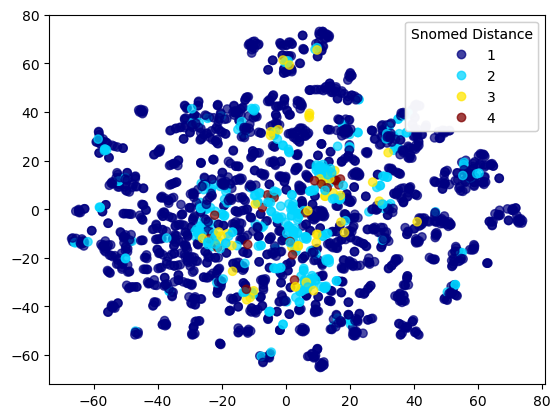

In [130]:
# TSNE
tsne = TSNE(n_components=2, random_state=0)
weighted_node_embeddings_2d = tsne.fit_transform(trimmed_weighted_node_embeddings)
# draw the points
alpha = 0.7

plt.figure(figsize=(10, 8))
fig, ax = plt.subplots()
scatter = ax.scatter(
    weighted_node_embeddings_2d[:, 0],
    weighted_node_embeddings_2d[:, 1],
    c=distance_arr,
    cmap="jet",
    alpha=0.7,
)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Snomed Distance")
ax.add_artist(legend1)
plt.show()

In [131]:
# Save
with open('weighted_walks_1000_trimmed.pickle', 'wb') as f:
    pickle.dump(weighted_walks_1000_3, f)

In [132]:
# To df
trimmed_snomed_embedding_128d = pd.DataFrame(trimmed_weighted_node_embeddings)
trimmed_snomed_embedding_128d.index = trimmed_node_ids
trimmed_snomed_embedding_128d.index.name = 'snomed_code'

In [133]:
trimmed_snomed_embedding_128d

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,...,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
snomed_code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
95324001,0.218880,-0.143242,0.279311,0.122627,-0.247978,-0.041680,0.252752,0.305453,-0.187868,0.350855,-0.028540,-0.283773,-0.395628,-0.010063,-0.253516,0.414326,0.055230,-0.440950,-0.298523,-0.236918,...,0.078870,-0.267850,-0.299966,0.246021,-0.057050,-0.510570,-0.075517,-0.067583,0.034248,-0.302752,0.094081,-0.303411,-0.041270,-0.164550,-0.028589,-0.074428,-0.130048,-0.148800,0.120522,-0.115371
81308009,-0.022543,0.034095,0.152589,-0.321631,-0.032552,0.227740,-0.077939,0.033574,0.048695,0.061036,-0.095946,-0.059924,-0.064917,-0.228700,-0.061442,0.155336,0.308956,0.054191,0.194345,-0.305732,...,-0.033207,0.008570,-0.189741,-0.253014,0.105711,0.039153,-0.122667,-0.007193,-0.028763,-0.051796,-0.115747,-0.054356,0.300723,-0.184051,-0.317587,-0.205256,0.051937,-0.077652,-0.453418,0.019214
363346000,-0.145293,0.198760,-0.011546,0.151815,-0.030025,0.155092,-0.119732,0.113912,-0.276302,0.127577,-0.432746,-0.157746,-0.271030,-0.390089,0.026623,0.204385,0.261260,0.187057,-0.213311,0.139741,...,0.191860,-0.326315,0.375689,-0.010472,0.388979,0.231447,-0.260248,0.043332,-0.195634,0.147868,0.278115,-0.127111,-0.190594,0.229352,-0.342326,0.174672,-0.153871,-0.213271,-0.303664,0.040939
64572001,-0.180752,0.065206,-0.033927,0.204637,-0.245122,0.086504,0.050831,-0.219228,-0.245577,-0.094911,0.061955,0.153709,0.215076,-0.088541,0.073527,0.028058,-0.024002,-0.169893,-0.170116,-0.279955,...,-0.067309,-0.052580,0.081515,0.080465,0.067147,-0.071376,0.017434,-0.050212,-0.064280,0.052706,0.134357,-0.063557,0.091572,0.136254,0.101521,-0.348531,-0.206637,0.165889,0.051839,-0.063793
128139000,0.170894,-0.121695,-0.101853,0.234205,-0.062576,0.194582,0.084485,-0.017592,0.226110,0.076484,-0.020925,-0.071149,0.091347,-0.002795,-0.142389,0.136991,0.159216,0.070433,0.093725,0.036001,...,-0.111051,0.159133,-0.245961,0.067101,0.005645,-0.124323,-0.358705,0.158840,0.176676,-0.141905,-0.053981,0.173552,0.387943,0.209794,0.016916,0.281639,-0.288956,0.034734,0.124148,-0.071868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414173003,0.328236,0.036208,-0.518049,-0.191841,0.232803,0.034512,-0.028654,-0.055711,-0.147230,-0.164026,0.203599,0.059382,0.036318,-0.054405,-0.289768,0.333492,0.246487,0.034020,0.291017,0.091053,...,-0.301622,0.102560,-0.224856,-0.163703,0.057657,-0.197870,-0.083812,-0.221851,-0.281258,-0.161922,-0.003623,0.104708,-0.318097,-0.195693,0.170051,0.137014,-0.018964,-0.381049,-0.378388,0.002424
16402000,-0.008512,-0.519395,-0.454137,0.221085,-0.212944,0.337702,-0.114009,0.050662,0.066568,-0.027212,0.018038,0.007249,0.328085,0.102455,-0.357802,0.138796,0.178324,-0.277072,0.131909,-0.192777,...,-0.196264,-0.145857,0.077847,0.031635,0.207262,-0.039875,-0.152718,0.047528,0.185640,0.453216,-0.014212,-0.261410,-0.076888,0.079155,0.231808,-0.297733,-0.246125,0.134378,-0.068948,0.311895
72366004,0.170411,0.117433,-0.194381,0.091406,-0.164469,-0.076155,0.013070,0.040411,0.133094,0.031991,-0.485661,-0.067446,-0.099734,0.059201,0.160592,0.013532,-0.043153,0.018084,0.150120,-0.326671,...,-0.279131,-0.048034,0.184019,-0.174622,0.041720,-0.179223,-0.051742,-0.113008,0.068055,-0.130766,-0.140571,-0.064658,0.170216,-0.069438,-0.168434,-0.107515,-0.134968,-0.175954,0.034550,0.105758


In [134]:
# Save
#trimmed_snomed_embedding_128d.to_csv('final_trimmed_snomed_embedding_128d.csv')